In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
#from google.colab import files
#from google.colab import drive
import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [24]:
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import datetime as datetime
import warnings
#from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [ ]:
###ARIMA

In [ ]:
#data=files.upload()
#uploading only San Juan training data
#sj_data = pd.read_csv(io.StringIO(data['dengue_dataset.csv'].decode('utf-8')))

In [12]:
sj_data = pd.read_csv('./Hands_On/Hands_on_Arima/dengue_dataset.csv')
sj_data.head()

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,1990,18,30-04-90,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,...,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1,1990,19,07-05-90,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,...,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
2,1990,20,14-05-90,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,...,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
3,1990,21,21-05-90,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,...,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
4,1990,22,28-05-90,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,...,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [14]:
ts_data = sj_data[['week_start_date', 'total_cases']].copy()
ts_data["week_start_date"] = pd.to_datetime(ts_data['week_start_date'], format='%d-%m-%y') 
ts_data.set_index('week_start_date', inplace=True)
ts_data.head()

,total_cases
week_start_date,
1990-04-30,4
1990-05-07,5
1990-05-14,4
1990-05-21,3
1990-05-28,6


In [15]:
ts_data.index.year

Int64Index([1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990, 1990,
            ...
            2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008],
           dtype='int64', name='week_start_date', length=936)

Text(0.5, 1.0, 'San Juan')

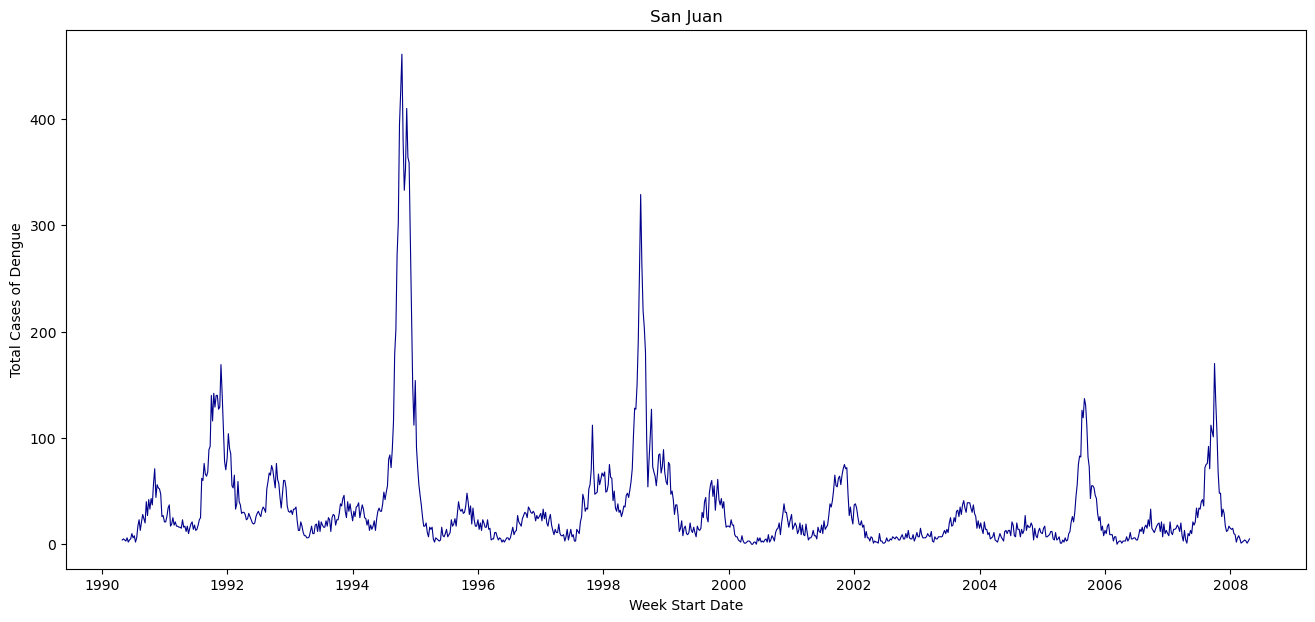

In [16]:
plt.figure(figsize=(16,7))
plt.plot(ts_data, color="darkblue", linewidth=.8) 
plt.xlabel("Week Start Date")
plt.ylabel("Total Cases of Dengue") 
plt.title("San Juan")


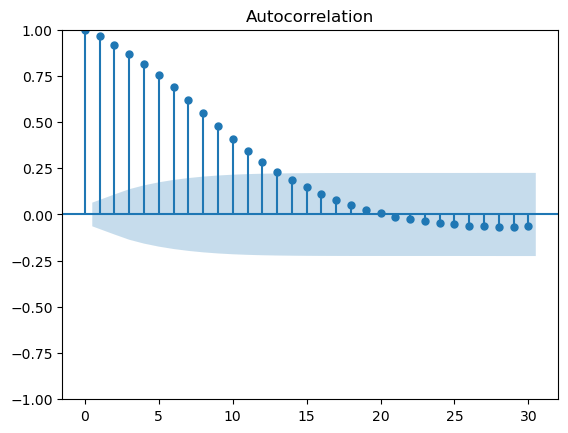

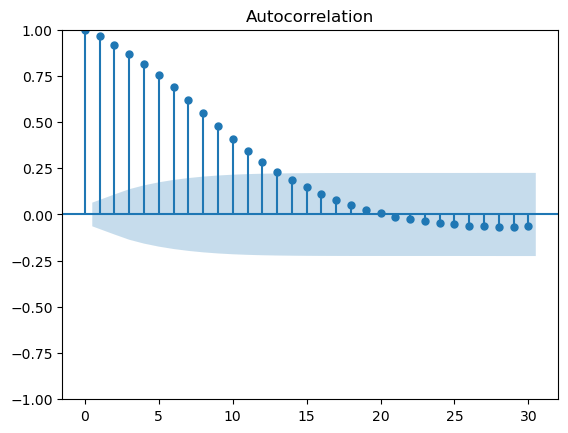

In [17]:
plot_acf(ts_data)

In [18]:
# pearson correlation coefficient 
def compute_covariance(x,y):
    x = np.asarray(x) 
    y = np.asarray(y) 
    mean_x = np.mean(x) 
    mean_y = np.mean(y) 
    std_x = np.std(x) 
    std_y = np.std(y) 
    l = len(x)
    return np.sum((x - mean_x)*(y-mean_y))/(std_x*std_y*l)

In [21]:
# computing variance indicating ACF
eda_ts = ts_data.copy()
shift = 13
eda_ts['shift'+str(shift)] = eda_ts.shift(shift) 
eda_ts.dropna(inplace=True)
eda_ts.head()
compute_covariance(x=eda_ts['total_cases'], y = eda_ts['shift'+str(shift)])

 

0.23285224943845023

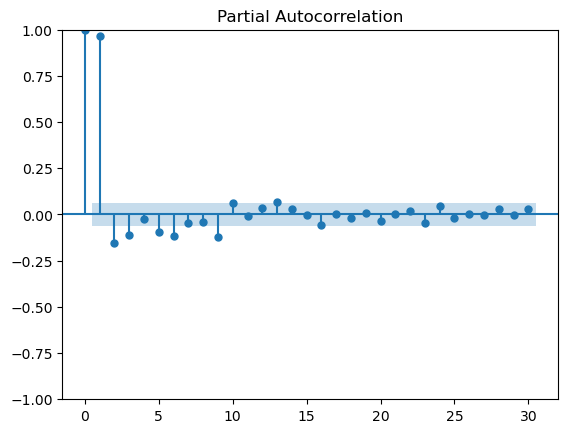

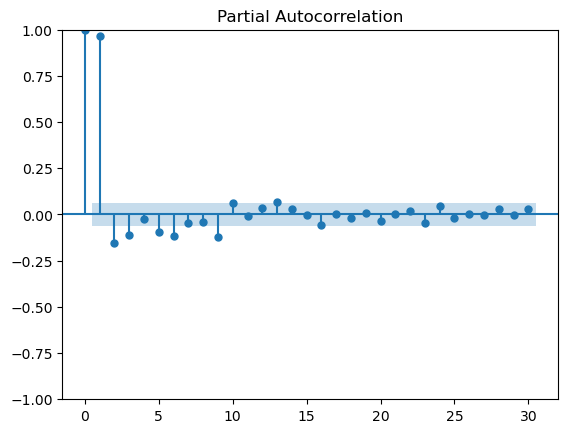

In [22]:
plot_pacf(ts_data)

In [25]:
# Test for stationarity 
result = adfuller(ts_data) 
print('p-value:', result[1])

p-value: 5.1473186737591e-09


In [26]:
X = ts_data.values
size = int(len(X) * 0.855)
train, test_actual = X[0:size], X[size:len(X)]
print("train size: %f, test size: %f, total size %f: "%(len(train), len(test_actual), len(ts_data)))

train size: 800.000000, test size: 136.000000, total size 936.000000: 


In [27]:
model = sm.tsa.arima.ARIMA(train, order=(2,0,1)) 
model_fit = model.fit()

In [28]:
#model = ARIMA(train, order=(2,0,1))
#model_fit = model.fit()
test_pred = [] # creating list to store new prediction for test set 
conf_int_low = [] #higher confidence interval
conf_int_high = [] #lower confidence interval
forecast_results = model_fit.get_forecast(steps=len(test_actual)) 
forecast = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

In [30]:
for t in range(len(test_actual)):
    conf_int_low.append(conf_int[t][0]) # adding low range of confidence interval 
    conf_int_high.append(conf_int[t][1]) # adding upper range of confidene interval 
    test_pred.append(forecast[t]) # adding single week prediction
    print('iteration :%s, predicted=%f, actual=%f' % (t+1, test_pred[t], test_actual[t]))

iteration :1, predicted=130.003010, actual=112.000000
iteration :2, predicted=127.778871, actual=82.000000
iteration :3, predicted=124.525527, actual=73.000000
iteration :4, predicted=120.429237, actual=43.000000
iteration :5, predicted=115.663435, actual=55.000000
iteration :6, predicted=110.387932, actual=55.000000
iteration :7, predicted=104.748419, actual=53.000000
iteration :8, predicted=98.876247, actual=46.000000
iteration :9, predicted=92.888445, actual=43.000000
iteration :10, predicted=86.887947, actual=29.000000
iteration :11, predicted=80.963990, actual=22.000000
iteration :12, predicted=75.192657, actual=26.000000
iteration :13, predicted=69.637545, actual=13.000000
iteration :14, predicted=64.350520, actual=17.000000
iteration :15, predicted=59.372543, actual=8.000000
iteration :16, predicted=54.734543, actual=13.000000
iteration :17, predicted=50.458318, actual=10.000000
iteration :18, predicted=46.557449, actual=17.000000
iteration :19, predicted=43.038212, actual=19.00

In [31]:
mse_error = mean_squared_error(test_actual, test_pred)
mae_error = mean_absolute_error(test_actual, test_pred)
print('Test Square MSE: %.3f and Test Absolute MAE: %.3f'% (mse_error, mae_error))

Test Square MSE: 1211.843 and Test Absolute MAE: 29.702


In [32]:
# plot
test_actual = pd.DataFrame(data=test_actual, index=ts_data[size:].index) 
test_pred = pd.DataFrame(data=test_pred, index=ts_data[size:].index) 
conf_int_low = pd.DataFrame(data=conf_int_low, index=ts_data[size:].index) 
conf_int_high = pd.DataFrame(data=conf_int_high, index=ts_data[size:].index)

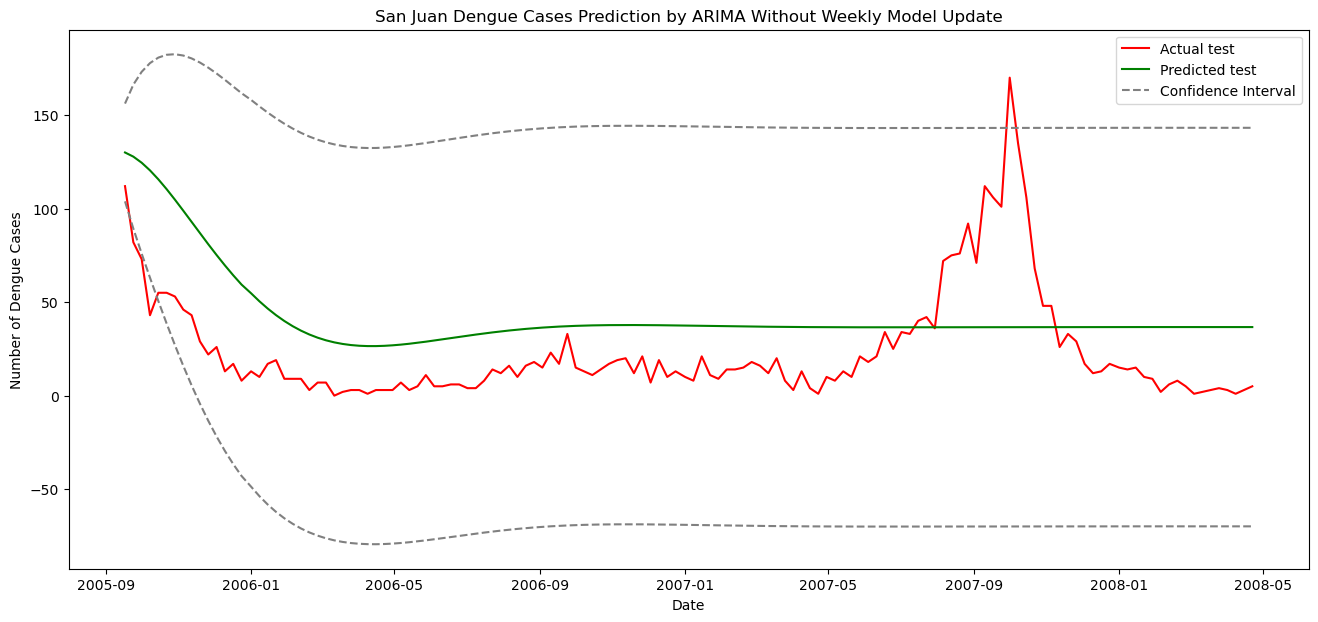

In [34]:
plt.figure(figsize=(16,7))
plt.plot(test_actual, color='red', label="Actual test")
plt.plot(test_pred, color='green', label="Predicted test")
plt.plot(conf_int_low, '--', color='grey', label="Confidence Interval") 
plt.plot(conf_int_high, '--', color='grey')
plt.legend()
plt.title("San Juan Dengue Cases Prediction by ARIMA Without Weekly Model Update") 
plt.ylabel("Number of Dengue Cases")
plt.xlabel("Date")
plt.savefig("ArimaPredictionWithoutUpdation_SJ.png")
plt.show()

In [35]:
X = ts_data.values
size = int(len(X) * 0.855)
train, test_actual = X[0:size], X[size:len(X)]
print("train size: %f, test size: %f, total size %f: "%(len(train), len(test_actual), len(ts_data)))

train size: 800.000000, test size: 136.000000, total size 936.000000: 


In [37]:
train = [x for x in train] # creating list of training data, just to make it model usable 
test_pred = [] # creating list to store new prediction for test set
conf_int_low = []
conf_int_high = []
for t in range(len(test_actual)):
    model = sm.tsa.arima.ARIMA(train, order=(2,0,1)) 
    model_fit = model.fit()
    
    forecast_results = model_fit.get_forecast(steps=1) 
    forecast = forecast_results.predicted_mean 
    conf_int = forecast_results.conf_int()
    
    yhat = forecast[0] # next week prediction
    conf_int_low.append(conf_int[0][0]) # adding low range of confidence interval 
    conf_int_high.append(conf_int[0][1]) # adding upper range of confidene interval 
    test_pred.append(yhat) # adding single week prediction
    train.append(test_actual[t]) # adding actual test value to train set to make next prediction 
    print('iteration :%s, predicted=%f, actual=%f' % (t+1, test_pred[t], test_actual[t]))

iteration :1, predicted=130.003010, actual=112.000000
iteration :2, predicted=108.183707, actual=82.000000
iteration :3, predicted=75.320607, actual=73.000000
iteration :4, predicted=66.459978, actual=43.000000
iteration :5, predicted=34.745426, actual=55.000000
iteration :6, predicted=49.813067, actual=55.000000
iteration :7, predicted=50.782700, actual=53.000000
iteration :8, predicted=49.350967, actual=46.000000
iteration :9, predicted=42.392133, actual=43.000000
iteration :10, predicted=39.865807, actual=29.000000
iteration :11, predicted=25.312463, actual=22.000000
iteration :12, predicted=18.714171, actual=26.000000
iteration :13, predicted=24.089764, actual=13.000000
iteration :14, predicted=10.592299, actual=17.000000
iteration :15, predicted=15.847236, actual=8.000000
iteration :16, predicted=6.653040, actual=13.000000
iteration :17, predicted=12.847008, actual=10.000000
iteration :18, predicted=9.987291, actual=17.000000
iteration :19, predicted=17.964253, actual=19.000000
it

In [38]:
mse_error = mean_squared_error(test_actual, test_pred)
mae_error = mean_absolute_error(test_actual, test_pred)
print('Test Square MSE: %.3f and Test Absolute MAE: %.3f'% (mse_error, mae_error))

Test Square MSE: 140.521 and Test Absolute MAE: 7.191


In [39]:
# plot
test_actual = pd.DataFrame(data=test_actual, index=ts_data[size:].index) 
test_pred = pd.DataFrame(data=test_pred, index=ts_data[size:].index) 
conf_int_low = pd.DataFrame(data=conf_int_low, index=ts_data[size:].index) 
conf_int_high = pd.DataFrame(data=conf_int_high, index=ts_data[size:].index)

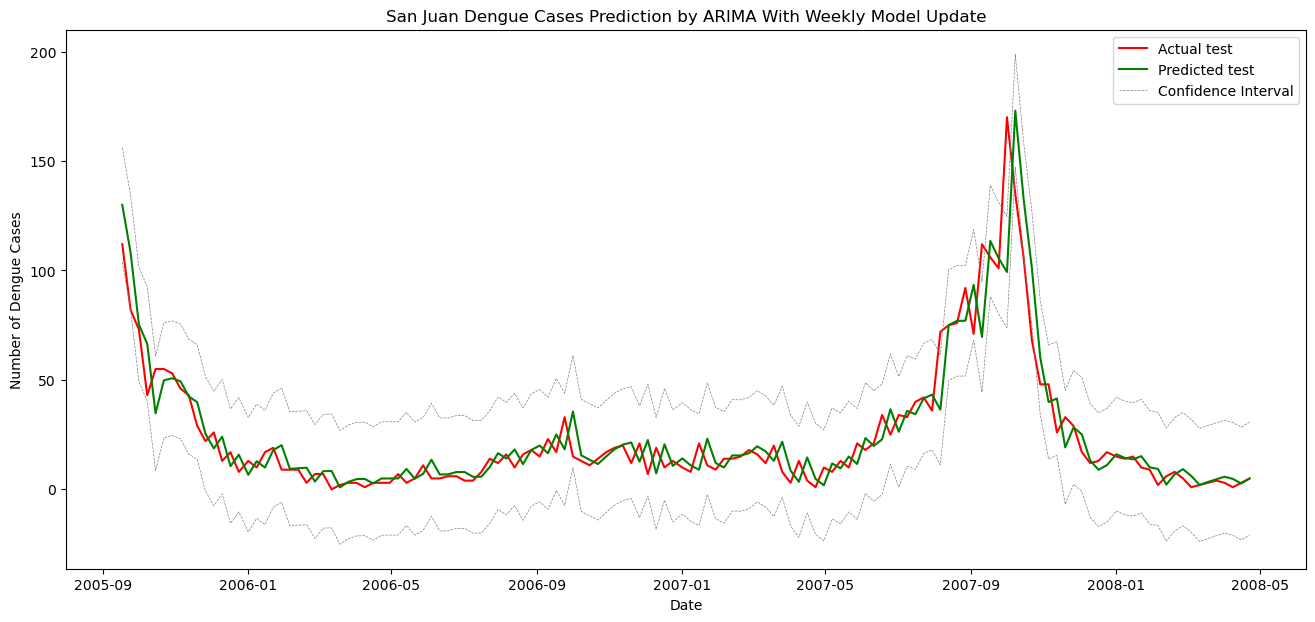

In [41]:
plt.figure(figsize=(16,7))
plt.plot(test_actual, color='red', label="Actual test")
plt.plot(test_pred, color='green', label="Predicted test")
plt.plot(conf_int_low, '--', linewidth = .5, color='grey', label="Confidence Interval") 
plt.plot(conf_int_high, '--', linewidth = .5, color='grey')
plt.legend()
plt.title("San Juan Dengue Cases Prediction by ARIMA With Weekly Model Update") 
plt.ylabel("Number of Dengue Cases")
plt.xlabel("Date")
plt.savefig("ArimaPredictionWithUpdation_SJ.png")
plt.show()

In [54]:
###LSTM

In [6]:
from sklearn import preprocessing

In [13]:
df = pd.read_csv("./Hands_On/Hands_on_Preprocessing/dengue_features_train.csv")
labels = pd.read_csv("./Hands_On/Hands_on_Preprocessing/dengue_labels_train.csv")

In [14]:
data = pd.merge(df, labels, on=['city', 'year', 'weekofyear'])
data.shape

(1456, 25)

In [16]:
sj = data[data['city'] == 'sj'].drop('city', axis=1)
sj['week_start_date'] = pd.to_datetime(sj['week_start_date'])
sj.index = sj['week_start_date']
sj.shape

(936, 24)

In [17]:
train_sj = sj.iloc[:800]
test_sj = sj.iloc[793:]
display(train_sj.shape)
display(test_sj.shape)
display(test_sj.head())
display(test_sj.tail())

(800, 24)

(143, 24)

,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
2005-07-30,2005,30,2005-07-30,-0.10870,-0.009450,0.256443,0.215371,64.25,300.852857,300.921429,...,82.408571,64.25,19.114286,2.728571,28.928571,6.171429,32.2,23.9,73.8,75
2005-08-06,2005,31,2005-08-06,-0.06475,-0.026700,0.140400,0.121200,80.34,301.158571,301.107143,...,79.621429,80.34,18.831429,2.871429,28.942857,5.928571,33.3,25.0,41.0,83
2005-08-13,2005,32,2005-08-13,NaN,0.023650,0.269129,0.191929,18.15,301.348571,301.378571,...,79.252857,18.15,18.938571,2.985714,29.471429,6.971429,33.9,25.6,12.6,82
2005-08-20,2005,33,2005-08-20,0.04790,0.069675,0.086329,0.095871,29.86,301.465714,301.464286,...,77.740000,29.86,18.720000,3.414286,29.328571,6.500000,33.3,25.6,18.1,126
2005-08-27,2005,34,2005-08-27,-0.12240,0.051000,0.105771,0.141871,99.02,301.178571,301.221429,...,76.734286,99.02,18.174286,3.385714,27.928571,7.928571,33.3,22.8,31.7,119


,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,...,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,
2008-03-25,2008,13,2008-03-25,0.07785,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,...,74.247143,27.19,13.644286,2.885714,25.042857,5.785714,30.0,21.1,1.8,4
2008-04-01,2008,14,2008-04-01,-0.03800,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,...,74.600000,3.82,14.662857,2.714286,26.242857,6.814286,30.6,22.2,0.5,3
2008-04-08,2008,15,2008-04-08,-0.15520,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,...,75.027143,16.96,14.184286,2.185714,25.000000,5.714286,29.4,21.7,30.7,1
2008-04-15,2008,16,2008-04-15,0.00180,NaN,0.203900,0.209843,0.00,297.630000,297.778571,...,72.285714,0.00,13.858571,2.785714,25.314286,6.242857,29.4,21.7,11.2,3
2008-04-22,2008,17,2008-04-22,-0.03700,-0.010367,0.077314,0.090586,0.00,298.672857,298.692857,...,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3,5


In [18]:
# Dropping unnecessary columns
columns_to_drop = ['precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_max_air_temp_k', 
                   'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_sat_precip_amt_mm', 
                   'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'reanalysis_tdtr_k', 'week_start_date']

train_sj = train_sj.drop(columns_to_drop, axis=1)
test_sj = test_sj.drop(columns_to_drop, axis=1)


In [19]:
display(train_sj.shape)
display(test_sj.shape)

(800, 11)

(143, 11)

In [20]:
print(len(columns_to_drop))

13


In [21]:
# Filling NaN values and scaling
train_sj.fillna(0, inplace=True)
test_sj.fillna(0, inplace=True)

for col in train_sj.columns:
    train_sj[col] = preprocessing.scale(train_sj[col].values)
    test_sj[col] = preprocessing.scale(test_sj[col].values)


In [22]:
display(train_sj.head())
display(test_sj.head())

,year,weekofyear,reanalysis_dew_point_temp_k,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,
1990-04-30,-1.687599,-0.574522,-0.019041,-0.651243,-1.148243,-0.510123,0.150730,-0.629886,-0.983822,-0.348505,-0.589953
1990-05-07,-1.687599,-0.507307,0.041217,-0.124100,-0.502674,-0.041190,-0.367579,0.089582,-0.091926,-0.604207,-0.571438
1990-05-14,-1.687599,-0.440091,0.099347,0.492782,0.197821,-0.041190,-0.255512,0.245988,0.151318,0.529172,-0.589953
1990-05-21,-1.687599,-0.372876,0.094475,0.266837,0.114413,0.238062,0.024655,0.590081,0.354022,-0.763156,-0.608467
1990-05-28,-1.687599,-0.305661,0.114524,0.283016,0.369385,0.780760,2.574175,1.121861,0.597266,-0.700959,-0.552923


,year,weekofyear,reanalysis_dew_point_temp_k,reanalysis_relative_humidity_percent,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,
2005-07-30,-1.625844,0.221452,1.491253,2.085037,1.525771,1.243359,-0.466523,0.387143,0.814595,1.389713,1.354758
2005-08-06,-1.625844,0.286080,1.311340,1.064732,1.351563,1.252433,-0.778437,0.951009,1.563927,0.341922,1.587118
2005-08-13,-1.625844,0.350708,1.358545,0.929807,1.417551,1.588145,0.560957,1.258572,1.972654,-0.565312,1.558073
2005-08-20,-1.625844,0.415336,1.247212,0.375986,1.282935,1.497412,-0.044522,0.951009,1.972654,-0.389616,2.836055
2005-08-27,-1.625844,0.479964,0.938153,0.007819,0.946837,0.608228,1.790264,0.951009,0.065263,0.044834,2.632739


In [23]:
X_train_sj = train_sj.drop('total_cases', axis=1).values
y_train_sj = train_sj['total_cases'].values

In [24]:
# print(len(X_train_sj))
# print(y_train_sj)
range(7,len(X_train_sj))

range(7, 800)

In [25]:
sj_train_x, sj_train_y = [], []
for i in range(7, len(X_train_sj)):
    sj_train_x.append(X_train_sj[i-7:i])
    sj_train_y.append(y_train_sj[i])
sj_train_x, sj_train_y = np.array(sj_train_x), np.array(sj_train_y)

In [26]:
print(len(sj_train_x))
print(len(sj_train_y))

793
793


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model_sj = Sequential()
model_sj.add(LSTM(units=50, return_sequences=True, input_shape=(sj_train_x.shape[1], sj_train_x.shape[2])))
model_sj.add(LSTM(units=50))
model_sj.add(Dense(1))

model_sj.compile(loss='mean_squared_error', optimizer='adam')

/opt/miniconda3/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
model_sj.fit(sj_train_x, sj_train_y, epochs=40, batch_size=1, verbose=1)

Epoch 1/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8443
Epoch 2/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7718
Epoch 3/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4701
Epoch 4/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4169
Epoch 5/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2979
Epoch 6/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3151
Epoch 7/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2842
Epoch 8/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2919
Epoch 9/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1830
Epoch 10/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1276
Epoch 11/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1696
Epoch 12/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1511
Epoch 13/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1463
Epoch 14/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1185
Epoch 15/40
793/793 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - lo

In [29]:
X_test_sj = test_sj.drop('total_cases', axis=1).values
y_test_sj = test_sj['total_cases'].values

sj_test_x, sj_test_y = [], []
for i in range(7, len(X_test_sj)):
    sj_test_x.append(X_test_sj[i-7:i])
    sj_test_y.append(y_test_sj[i])
sj_test_x, sj_test_y = np.array(sj_test_x), np.array(sj_test_y)


In [30]:
model_sj.evaluate(sj_test_x, sj_test_y)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7398  


3.8169875144958496

In [31]:
# Extracting the index (dates) from the test sets before transforming them to numpy arrays
sj_test_dates = test_sj.index[7:]  # Assuming the test data transformation starts from the 7th index


In [32]:
# Predicting the test set
y_pred_sj = model_sj.predict(sj_test_x)
y_pred_sj = [int(round(y[0])) for y in y_pred_sj]  # Flatten and round-off to the nearest integer
# Assuming you still have the original training dataframe
sj_train_dates = train_sj.index[7:]  # Adjust the starting index as per your sequence creation logic
# Making predictions on the training data
y_train_pred_sj = model_sj.predict(sj_train_x)
y_train_pred_sj = [int(round(y[0])) for y in y_train_pred_sj]  # Flatten and round-off to the nearest integer


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


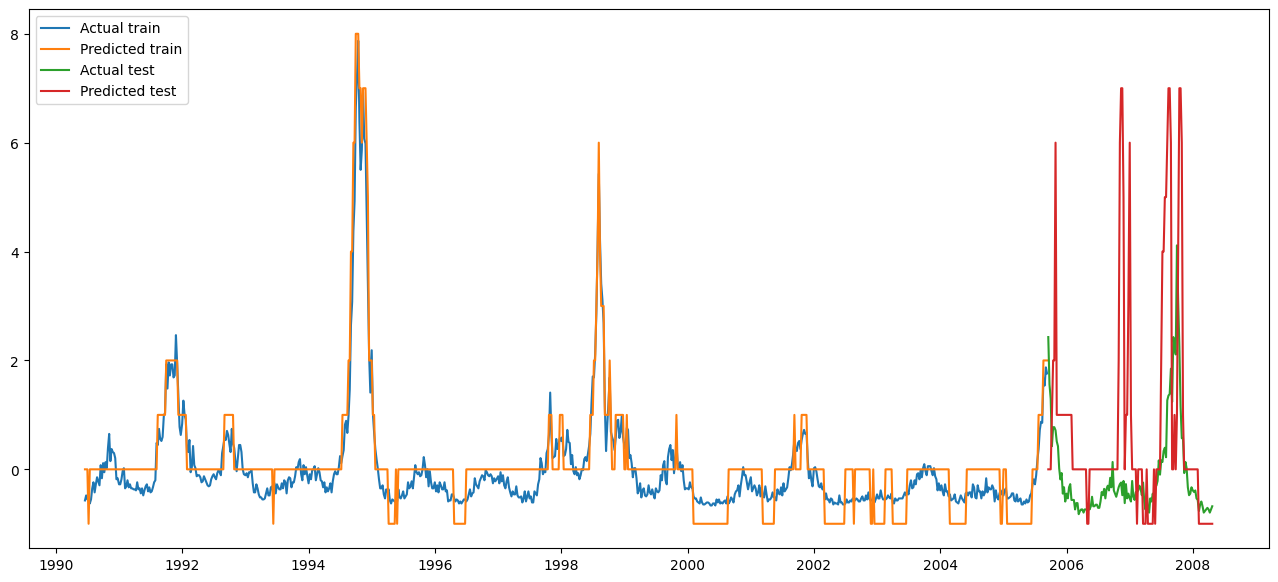

In [33]:
# Now, you can plot without encountering the NameError
fig = plt.figure(figsize=(16,7))
plt.plot(sj_train_dates, y_train_sj[7:], label="Actual train")  # Adjusted to match the length of sj_train_dates
plt.plot(sj_train_dates, y_train_pred_sj, label="Predicted train")  # Assuming y_train_pred_sj is already defined
plt.plot(sj_test_dates, y_test_sj[7:], label="Actual test")  # Adjusted to match the length of sj_test_dates
plt.plot(sj_test_dates, y_pred_sj, label="Predicted test")  # Assuming y_pred_sj is already defined
plt.legend()